In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from transformers import ViTForImageClassification
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Data Augmentation (Enhanced Stability)
# ==============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load MRI Dataset
# ==============================
train_dataset = datasets.ImageFolder(root="/kaggle/input/final-alzheimer-dataset/output/Train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="/kaggle/input/final-alzheimer-dataset/output/Test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load Pretrained ViT Model
# ==============================
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Increased dropout for regularization
    nn.Linear(model.config.hidden_size, num_classes)
)
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Define Loss, Optimizer & Scheduler
# ==============================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for stability
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)  # Longer annealing

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    accumulation_steps = 2  # Gradient Accumulation

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        optimizer.zero_grad()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize loss
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ==============================
        # Validation Step
        # ==============================
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:

# Train the model
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)


Epoch [1/10] - Train Loss: 0.7846, Train Acc: 74.18% | Val Loss: 0.8287, Val Acc: 69.88%
Epoch [2/10] - Train Loss: 0.6643, Train Acc: 80.46% | Val Loss: 0.7637, Val Acc: 74.54%
Epoch [3/10] - Train Loss: 0.6418, Train Acc: 82.04% | Val Loss: 0.6942, Val Acc: 82.33%
Epoch [4/10] - Train Loss: 0.6280, Train Acc: 82.96% | Val Loss: 0.6834, Val Acc: 82.75%
Epoch [5/10] - Train Loss: 0.5935, Train Acc: 85.71% | Val Loss: 0.6827, Val Acc: 82.17%
Epoch [6/10] - Train Loss: 0.5730, Train Acc: 87.03% | Val Loss: 0.6536, Val Acc: 82.79%
Epoch [7/10] - Train Loss: 0.5575, Train Acc: 87.83% | Val Loss: 0.6688, Val Acc: 82.04%
Epoch [8/10] - Train Loss: 0.5460, Train Acc: 88.73% | Val Loss: 0.5905, Val Acc: 86.25%
Epoch [9/10] - Train Loss: 0.5142, Train Acc: 91.07% | Val Loss: 0.5504, Val Acc: 87.96%
Epoch [10/10] - Train Loss: 0.5007, Train Acc: 91.54% | Val Loss: 0.5735, Val Acc: 86.17%


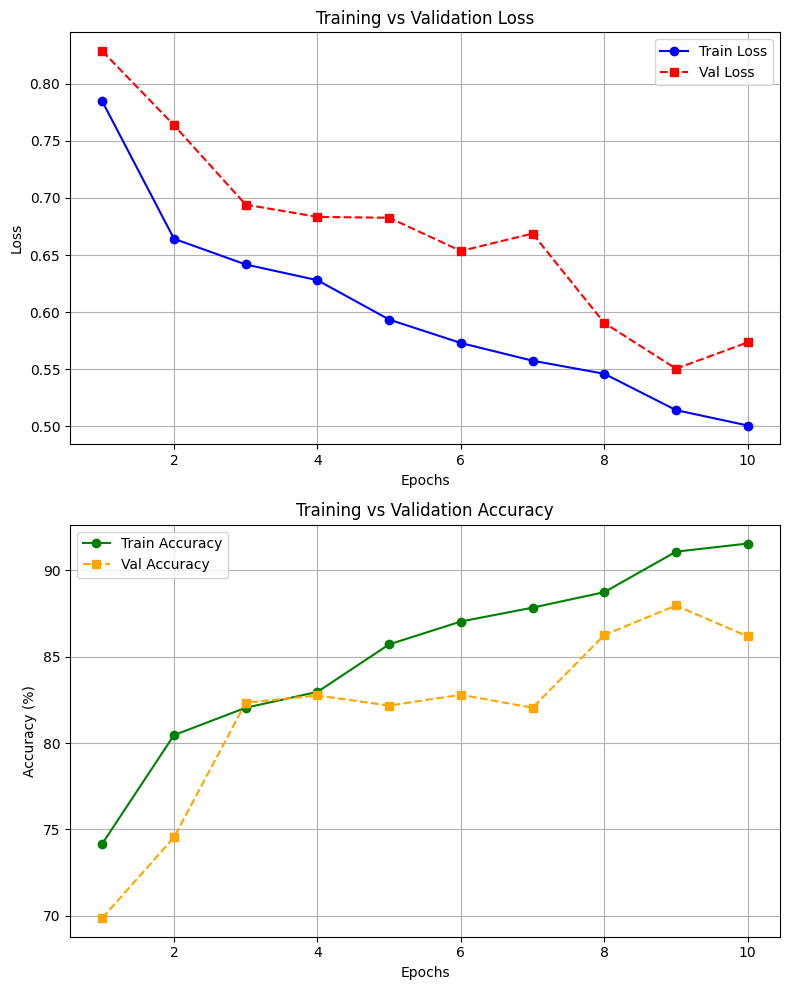

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # 🔹 Loss Curve
    axs[0].plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, val_losses, label='Val Loss', color='red', linestyle='dashed', marker='s')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_title('Training vs Validation Loss')

    # 🔹 Accuracy Curve
    axs[1].plot(epochs, train_accs, label='Train Accuracy', color='green', marker='o')
    axs[1].plot(epochs, val_accs, label='Val Accuracy', color='orange', linestyle='dashed', marker='s')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_title('Training vs Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Call the function with your training results
plot_training_curves(train_losses, val_losses, train_accs, val_accs)


Classification Report:
                   precision    recall  f1-score   support

ModerateDemented       0.97      1.00      0.99       600
     NonDemented       0.89      0.68      0.77       600
VeryMildDemented       0.69      0.89      0.78       600
    mildDemented       0.95      0.88      0.92       600

        accuracy                           0.86      2400
       macro avg       0.88      0.86      0.86      2400
    weighted avg       0.88      0.86      0.86      2400



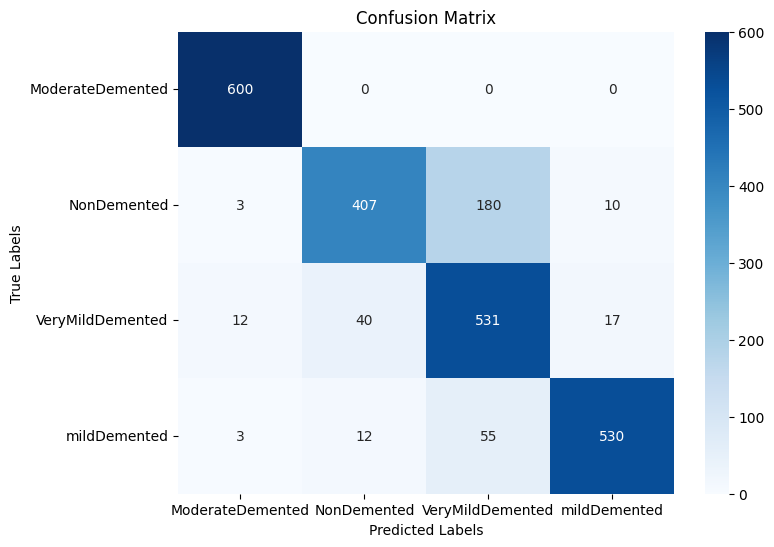

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, val_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Get class names from dataset
class_names = train_dataset.classes  # Assuming dataset is loaded with ImageFolder

# Call the function
evaluate_model(model, val_loader, device, class_names)


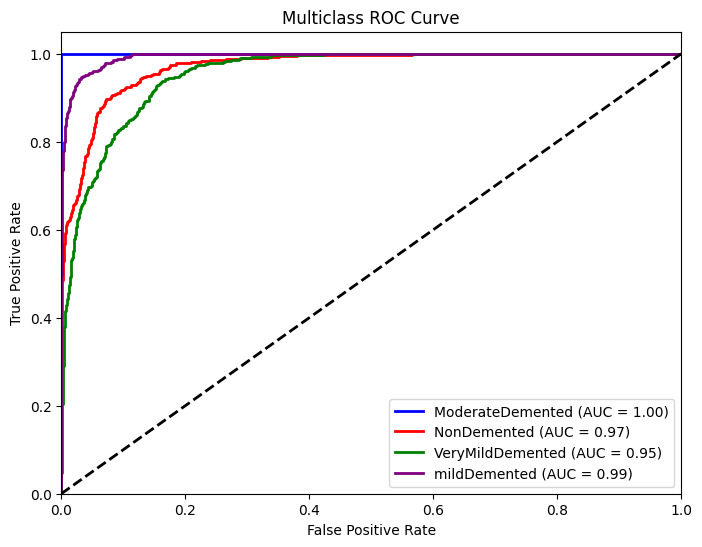

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import torch

def plot_roc_curve(model, val_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Get logits
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binarize the labels for ROC curve
    n_classes = len(class_names)
    all_labels_bin = label_binarize(all_labels, classes=range(n_classes))

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green", "purple"])

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Get class names from dataset
class_names = train_dataset.classes  # Assuming dataset is loaded with ImageFolder

# Call the function
plot_roc_curve(model, val_loader, device, class_names)


In [ ]:
import torch

# Define path to save model
MODEL_PATH = "vit_alzheimer_model.pth"

# Save model state dictionary
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ Model saved successfully at {MODEL_PATH}")


✅ Model saved successfully at vit_alzheimer_model.pth
